In [1]:
"""""
 *  \brief     ml_test.ipynb
 *  \author    Jonathan Reymond
 *  \version   1.0
 *  \date      2023-02-14
 *  \pre       None
 *  \copyright (c) 2022 CSEM
 *
 *   CSEM S.A.
 *   Jaquet-Droz 1
 *   CH-2000 Neuchâtel
 *   http://www.csem.ch
 *
 *
 *   THIS PROGRAM IS CONFIDENTIAL AND CANNOT BE DISTRIBUTED
 *   WITHOUT THE CSEM PRIOR WRITTEN AGREEMENT.
 *
 *   CSEM is the owner of this source code and is authorised to use, to modify
 *   and to keep confidential all new modifications of this code.
 *
 """

os.chdir('/local/user/jrn/tinyml-challenge-2022')
sys.path.insert(0, '/local/user/jrn/tinyml-challenge-2022/ml_training')
sys.path.insert(0, '/local/user/jrn/tinyml-challenge-2022/ml_training/preprocess_data')
from preprocess_data.prepare_data import get_final_dataframe
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tf_to_tflite import *
from tensorflow import keras
from sklearn.model_selection import train_test_split
from constants_ml import *
from sklearn.metrics import classification_report, confusion_matrix
from models import models_dict
import random
from utils import *

import dataloader
from collections import Counter


sys.path.insert(0, 'ml_training/')
sys.path.insert(0, 'ml_training/preprocess_data')
from preprocess_data.constants import SAMPLING_FREQUENCY, INDEX_HOURS, get_result_filename
sys.path.insert(0, 'ml_training/tools')
from tools import print_progress_bar


2023-02-04 08:25:19.901625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 08:25:22.417875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-04 08:25:22.417964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-04 08:25:22.417977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Tflite model generation correction

In [39]:
lowpass_freq = None
merge_bucket_size = 1
resample_frequency = None #SAMPLING_FREQUENCY / 2
to_mfcc = False
index_hours = range(85, 89)
df = get_final_dataframe(merge_bucket_size, lowpass_freq, resample_frequency, to_mfcc, index_hours)
X = df['audio'].to_list()
labels = df['rain_count'].to_numpy()

    
X_list = [np.split(xi, SPLIT_FACTOR) for xi in X]
X = list(itertools.chain.from_iterable(X_list))
X = np.expand_dims(X, axis=-1)
labels = np.repeat(labels, SPLIT_FACTOR)

Dataset already computed, loading from pickle


In [41]:
df.columns

Index(['timestamp', 'humidity', 'pressure', 'temperature', 'audio', 'wind_dir',
       'wind_count', 'rain_count', 'wind_x', 'wind_y'],
      dtype='object')

In [40]:
len(X)

10996

In [7]:
x_tr, x_te, y_tr, y_te = train_test_split(X, labels, test_size=0.3, random_state=1)


In [14]:
def representative_data_gen(X):
    for xi in X:
        # need reshape (batch=1, size=32000, channel=1)
        yield [np.array(xi, dtype=np.float32).reshape((1,-1, 1))]

def get_tflite_interpreter2(model, with_optimization, with_quantization, store_path=None, X=None):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if with_optimization:
        converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY, tf.lite.Optimize.DEFAULT]
    if with_quantization:
        X_r = X[5000:]
        np.random.shuffle(X_r)
        converter.representative_dataset = lambda : representative_data_gen(X_r)
        # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] 
    tflite_model_ = converter.convert()
    if store_path is not None:
        tflite_model_file = pathlib.Path(store_path)
        tflite_model_file.write_bytes(tflite_model_)

    interpreter = tf.lite.Interpreter(model_content=tflite_model_)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]['index']
    output_details = interpreter.get_output_details()[0]['index']
    return {'interpreter': interpreter, 'input':input_details, 'output':output_details}

def is_correct(labels, outputs):
    pred = outputs.argmax(axis=2)
    return np.equal(labels, pred).astype(int)

# for multiple inputs
def tflite_eval(interpreter_dict, X):
    interpreter = interpreter_dict['interpreter']
    res = []
    for i in range(len(X)):
        if (i + 1)% 100 == 0 :
            print('tflite evaluation :', i + 1, len(X), end="\r")
        
        interpreter.set_tensor(interpreter_dict['input'], X[i])
        interpreter.invoke()
        output_sample = interpreter.get_tensor(interpreter_dict['output'])
        res.append(output_sample)
    print()
    return np.asarray(res)

# for multiple inputs
def tf_eval(tf_model, X):
    infer_tf_model = tf_model.signatures["serving_default"]
    res = []
    for i in range(len(X)):
        if (i  + 1) % 100  == 0 :
            print('tf evaluation :', i + 1, len(X), end="\r")
        output_sample = infer_tf_model(X[i])['dense_2'].numpy()
        res.append(output_sample)
    print()
    return res

In [15]:
tflite_model = get_tflite_interpreter2(model, True, True, store_path="/local/user/jrn/tinyml-challenge-2022/results/m_test.tflite", X=X)

INFO:tensorflow:Assets written to: /tmp/tmpt2clzg17/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2clzg17/assets
2022-11-14 16:47:04.177458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-11-14 16:47:04.177482: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-11-14 16:47:04.177659: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpt2clzg17
2022-11-14 16:47:04.182251: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-11-14 16:47:04.182266: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpt2clzg17
2022-11-14 16:47:04.200302: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-11-14 16:47:04.250867: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpt2clzg17
2022-11-14 16:47:04.278226: I tensorflow/cc/saved_model/loader.cc:301] SavedMode

In [16]:

x_te_tflite = [tf.convert_to_tensor(xi.reshape(1, -1, 1)) for xi in x_te]
res_tflite = tflite_eval(tflite_model, x_te_tflite)


tflite evaluation : 3200 3299


In [17]:
res_tflite[:20]

array([[[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.94140625, 0.05078125, 0.0078125 ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.00390625, 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.53125   , 0.375     , 0.09375   ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.20703125, 0.6484375 , 0.14453125]]], dtype=float32)

In [31]:
res_tflite[:, :, 0]

array([[0.09609374],
       [0.09609374],
       [0.09609374],
       ...,
       [0.09609374],
       [0.09609374],
       [0.09609374]], dtype=float32)

In [37]:
res_tflite[:, :, 0] += 0.02 
pred_tflite = np.argmax(res_tflite, 2).flatten()

# print(confusion_matrix(pred_tf, labels_test))
print(confusion_matrix(pred_tflite, y_te))

acc = np.sum((pred_tflite == y_te).astype(np.int16)) / len(y_te)
print(acc)

[[2327  543  154]
 [ 106   94   61]
 [   6    1    7]]
0.7359806001818733


In [19]:
y_pred = np.asarray(model.predict(x_te, verbose=0))
y_pred = y_pred.argmax(axis=1)

print(confusion_matrix(y_pred, y_te))
acc = np.sum((y_pred == y_te).astype(np.int16)) / len(y_te)
print(acc)

[[2081  144   13]
 [ 245  385   63]
 [ 113  109  146]]
0.7917550772961504


## Test values

In [ ]:
def wav_to_pcm(arr):
    arr = arr.reshape((-1))
    res = []
    for val in arr :
        val = val* 2**15
        if val < 0 :
            val += 2**16
        res.append(int(val))
    return res
    

In [ ]:
zeros_wav = np.zeros((1, 4096, 1), dtype=np.float32)
zeros_pcm = wav_to_pcm(zeros_wav)
print('zero value:', tflite_eval(tflite_interp_quant, [zeros_wav]))
# print('pcm:', zeros_pcm)
# print('wav:', list(zeros_wav.reshape((-1))))


In [ ]:
wav = (np.arange(4096* 10, step = 10)/ 409600).reshape((1, 4096, 1)).astype(np.float32)

zeros_pcm = wav_to_pcm(zeros_wav)
print('zero value:', tflite_eval(tflite_interp_quant, [wav]))

In [ ]:
sample_wav = np.array(X_test[2100], dtype=np.float32)
sample_pcm = wav_to_pcm(sample_wav)
print('sample value:', tflite_eval(tflite_interp_quant, [sample_wav]))
print('pcm:', sample_pcm)
print()
print('wav:', list(sample_wav.reshape((-1))))

## Plots

In [22]:
# Final 
arr1 = [[584,  40,  38],
 [ 59, 176,  77],
 [  9,  27, 101]]
acc1 = 0.7749775052070618

arr2 = [[584,  78],
 [ 68, 381]]
acc2 = 0.8685868586858686



# arr1 = [[1816,  514 ,  30],
#  [ 598, 1513,  350],
#  [  44,  393, 1437]]

# arr2 = [[4441,  380],
#  [ 437, 1437]]



name = 'rain'

if name == 'rain':
    # arr1=[[9270,  397,   68],
    # [1035, 1481,  205],
    # [  55,  192,  687]]
    # wind
    
#     arr1 = np.array([[7711, 1038,   17],
#        [ 481, 2682,  315],
#        [   0,   22,  215]])
    
    # arr1 = [[4990,  778,  104],
    #     [ 338, 1232,  247],
    #     [   0 ,  75,  604]]
    arr1 = np.array([[7248, 1354,  149,   15],
       [ 304, 1394,  298,   19],
       [   9,  230, 1024,  200],
       [   0,    0,   36,  201]])
    arr1 = np.array([[7661, 1081,   24],
 [ 464, 2634,  380],
 [   0,   25,  212]])
    # tflite
    arr1 = np.array([[   75 , 4962 ,65559],
 [    0  ,1062  ,8293],
 [    0  ,  58 , 1532]])

    # arr1 = np.array([[7407, 1244,  102,   13],
    #    [ 329, 1385,  285,   16],
    #    [  14,  247,  999,  203],
    #    [   0,    2,   31,  204]])

    # arr2=[[12183,   273],
    # [  247,   687]]
    arr2 = [[7338, 351],
            [75,  604]]
else :
    #wind
    # arr1=[[3362, 1235 ,  47],
    #  [1104, 3315 , 504],
    #  [  78,  996 ,2749]]
    arr1 = np.array([[1348,  236,    7,    0],
       [2383, 5623, 1192,   40],
       [   6,  164,  970,  241],
       [   0,    9,   54,  208]])
    arr1 = np.array([[1376,  214,    1],
 [2592, 7178,  849],
 [   0,   24,  247]])

    arr2=[[9016,  551],
     [1074, 2749]]

arr1 = np.asarray(arr1, dtype=np.int16)
arr1 = arr1 / arr1.sum(axis=1).reshape((1, -1)).T

arr2 = np.asarray(arr2, dtype=np.int16)
arr2 = arr2 / arr2.sum(axis=1).reshape((1, -1)).T


In [17]:
[4990+ 778 + 338 + 1232, 104 + 247]

[7338, 351]

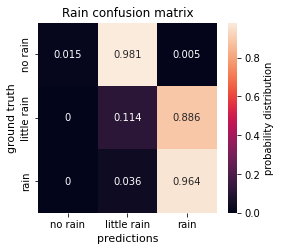

In [24]:
index_names = ['no ' + name, 'little ' + name, name]#, 'strong ' + name]

df_cm = pd.DataFrame(np.around(arr1, 3), index = index_names,
                  columns = index_names)
plt.figure(figsize = (4,3.5))
sns.heatmap(df_cm, annot=True, fmt='g', cbar_kws={'label': 'probability distribution'}).set_title(name.title() + ' confusion matrix')
plt.xlabel('predictions', fontsize=11)
plt.ylabel('ground truth', fontsize=11)
plt.savefig('confusion_matrix_last_3_' + name +'.png', dpi=150)

Text(14.999999999999996, 0.5, 'ground truth')

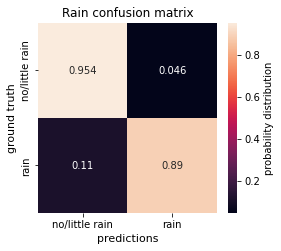

In [6]:
df_cm = pd.DataFrame(np.around(arr2, 3), index = [i for i in ['no/little ' + name, name]],
                  columns = ['no/little ' + name, name])
plt.figure(figsize = (4,3.5))
sns.heatmap(df_cm, annot=True, fmt='g', cbar_kws={'label': 'probability distribution'}).set_title(name.title() + ' confusion matrix')
plt.xlabel('predictions', fontsize=11)
plt.ylabel('ground truth', fontsize=11)
plt.savefig('confusion_matrix_htsat_' + name + '_binary.png', dpi=150)

## Draft 

In [3]:
df = dataloader.get_dataset()

extracting dataset
[=================================> ]  100.0%   24/24


In [30]:
def compress_labels2(x):
    if x < 6:
        return 0
    elif x < 12:
        return 1
    else :
        return 2

<AxesSubplot:xlabel='wind_count', ylabel='Count'>

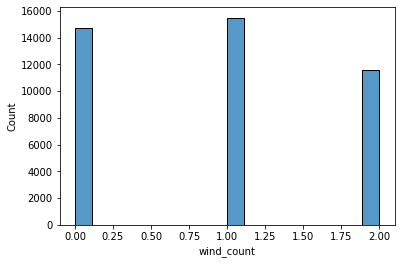

In [31]:
sns.histplot(df['wind_count'].map(compress_labels2))

<AxesSubplot:xlabel='wind_count', ylabel='Count'>

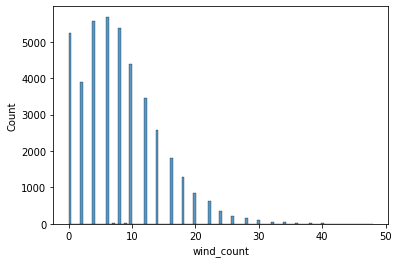

In [19]:
sns.histplot(df['wind_count'])

In [12]:
sorted(Counter(df['wind_count']).items())

[(0.0, 5243),
 (1.0, 1),
 (2.0, 3908),
 (3.0, 2),
 (4.0, 5583),
 (5.0, 4),
 (6.0, 5689),
 (7.0, 12),
 (8.0, 5373),
 (9.0, 12),
 (10.0, 4393),
 (11.0, 7),
 (12.0, 3452),
 (13.0, 5),
 (14.0, 2569),
 (15.0, 8),
 (16.0, 1807),
 (17.0, 2),
 (18.0, 1291),
 (19.0, 4),
 (20.0, 853),
 (21.0, 3),
 (22.0, 626),
 (23.0, 2),
 (24.0, 341),
 (26.0, 220),
 (28.0, 158),
 (29.0, 2),
 (30.0, 107),
 (32.0, 57),
 (34.0, 50),
 (36.0, 25),
 (38.0, 11),
 (40.0, 11),
 (42.0, 5),
 (44.0, 2),
 (46.0, 2),
 (48.0, 3)]

In [9]:
df = pd.read_pickle('/local/user/jrn/tinyml-challenge-2022/final_dataset_86_87_88.pkl')


,timestamp,humidity,pressure,temperature,audio,wind_dir,wind_count,rain_count,wind_x,wind_y
0,306002.389,0.884332,0.115592,0.185033,"[-0.05419922, -0.0541687, -0.0541687, -0.05419...",0.714286,0.0,0.0,0.500000,0.470588
1,306014.653,0.883627,0.110173,0.185033,"[-0.054473877, -0.05444336, -0.054504395, -0.0...",0.714286,0.0,0.0,0.500000,0.470588
2,306016.697,0.883479,0.116900,0.186590,"[-0.05456543, -0.054504395, -0.054382324, -0.0...",0.714286,0.0,0.0,0.500000,0.470588
3,306018.741,0.884464,0.109880,0.185967,"[-0.054504395, -0.054534912, -0.054504395, -0....",0.714286,0.0,0.0,0.500000,0.470588
4,306020.785,0.884464,0.109880,0.185967,"[-0.0546875, -0.0546875, -0.054626465, -0.0545...",0.714286,0.0,0.0,0.500000,0.470588
...,...,...,...,...,...,...,...,...,...,...
1028,319280.677,0.889803,0.147411,0.236120,"[-0.055145264, -0.055023193, -0.054992676, -0....",0.142857,4.0,1.0,0.588388,0.553777
1029,319284.765,0.890297,0.146627,0.235809,"[-0.054504395, -0.05456543, -0.054656982, -0.0...",0.285714,8.0,1.0,0.500000,0.705882
1030,319286.809,0.890991,0.148524,0.235497,"[-0.055419922, -0.055419922, -0.055114746, -0....",0.285714,8.0,1.0,0.500000,0.705882
1031,319288.853,0.891607,0.152053,0.235809,"[-0.05532837, -0.05529785, -0.05529785, -0.055...",0.285714,8.0,1.0,0.500000,0.705882


In [8]:
df['rain_count'].value_counts()

0.0    4053
1.0    1027
2.0     418
Name: rain_count, dtype: int64

## one hot encoding test

In [4]:
labels_rain = [0,2,4,1,1,1,3,3,2]
labels_wind = [1,2,3,0,0,1,3,1,2]
X = [0]
reformat_dataset(X, (labels_rain, labels_wind), True)

(array([[0]]),
 array([[1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0.]]),
 [5, 4])

In [6]:
import re
[m.end() for m in re.finditer('test', 'test test test test')]

[4, 9, 14, 19]

In [18]:
data = ["int zt;",
  "public int w = 3;",
  "public final int nu;public a(d dVar, int i, int i2);",
  "public int getScoreOrder() {int getInteger;",
  "for (int i = 0; i < this.nu; i++)",
  "{public a(d dVar, int t) {super(dVar, i);",
  "private int z = true ;if (getType() != 1) {z = false;",
  "protected int g = true;",
  "unprotected int z = true;if (getType() != 1) {z = false;",
  "public int getType() {return getInteger();",
  "int y;",
  "print (int i) {int k = b.k(parcel);"]

list_end = ["=",";",")","(",",", " "]



for s in data :
    for idx in [m.end() for m in re.finditer('int ', s)]:
        idx_end = idx
        while s[idx_end] not in list_end and idx_end < len(s):
            idx_end += 1
            
        print(s[idx:idx_end], len(s[idx:idx_end]),'   ',idx, s)
        
        # for sep in list_end :
        #     s = s.replace(sep, ' ')
        # print(s[idx:].split()[0])

zt 2     4 int zt;
w 1     11 public int w = 3;
nu 2     17 public final int nu;public a(d dVar, int i, int i2);
i 1     41 public final int nu;public a(d dVar, int i, int i2);
i2 2     48 public final int nu;public a(d dVar, int i, int i2);
getScoreOrder 13     11 public int getScoreOrder() {int getInteger;
getInteger 10     32 public int getScoreOrder() {int getInteger;
i 1     9 for (int i = 0; i < this.nu; i++)
t 1     22 {public a(d dVar, int t) {super(dVar, i);
z 1     12 private int z = true ;if (getType() != 1) {z = false;
g 1     14 protected int g = true;
z 1     16 unprotected int z = true;if (getType() != 1) {z = false;
getType 7     11 public int getType() {return getInteger();
y 1     4 int y;
 0     6 print (int i) {int k = b.k(parcel);
i 1     11 print (int i) {int k = b.k(parcel);
k 1     19 print (int i) {int k = b.k(parcel);


## Weighted crossentropy loss

In [85]:
def weighted_categorical_crossentropy(target, output, weights):
    idx1 = K.argmax(output, axis=1)
    idx2 = K.argmax(target, axis=1)
    mask = tf.gather_nd(weights, tf.stack((idx1, idx2), -1))
    print('mask', mask)
    return K.categorical_crossentropy(target, output) * mask

#assume weights from zero to n-1 (total number of classes)
def weights_to_matrix(weights_dict):
    num_classes = len(weights_dict)
    weights = ([weights_dict[i] for i in range(num_classes)])
    matrix = 1 - np.eye(num_classes)
    return (matrix * weights)

In [86]:
def weighted_categorical_crossentropy_new(target, output, weights_table):
    weights_vect = weights_table.lookup(K.argmax(target, axis=1))
    return K.categorical_crossentropy(target, output) * weights_vect

In [92]:
weights_dict = {0: 2, 1: 10, 2: 100}
weights_matrix = weights_to_matrix(weights_dict)
weights = ([weights_dict[i] for i in range(len(weights_dict))])

weights_table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            list(weights_dict.keys()),
            list(weights_dict.values()),
            key_dtype=tf.int64,
            value_dtype=tf.float64,
        ),
        default_value=-1)



In [94]:


target = tf.convert_to_tensor(np.array([[0,   0,   1], 
                                [1,   0,   0], 
                                [0,   1,   0], 
                                [1,   0,   0]], dtype=float))

output = tf.convert_to_tensor(np.array([[0,   0.9, 0.1], 
                                [0,   1,   0], 
                                [0, 0, 1], 
                                [0.1, 0.3, 0.6]]))

print('weights')
print(weights_dict)

print('target: ', K.argmax(target, axis=1), [weights_dict[i] for i in K.argmax(target, axis=1).numpy()])
print('output: ', K.argmax(output, axis=1), [weights_dict[i] for i in K.argmax(output, axis=1).numpy()])
# print('normal weighted')
# print(weighted_categorical_crossentropy(target, output, weights_matrix))
print('simplified weighted')
print(weighted_categorical_crossentropy_new(target, output, weights_table))
# print('unweighted')
K.categorical_crossentropy(target, output)


weights
{0: 2, 1: 10, 2: 100}
target:  tf.Tensor([2 0 1 0], shape=(4,), dtype=int64) [100, 2, 10, 2]
output:  tf.Tensor([1 1 2 2], shape=(4,), dtype=int64) [10, 10, 100, 100]
simplified weighted
tf.Tensor([230.2585093   32.2361913  161.18095651   4.60517019], shape=(4,), dtype=float64)


<tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 2.30258509, 16.11809565, 16.11809565,  2.30258509])>

## Draft

In [4]:
import tensorflow_models as tfm
import sys
import os
# os.chdir('/local/user/jrn/tinyml-challenge-2022')
os.system("module load cuda/11.2")
os.system("module load cudnn/8.1")


# import tensorflow_models as tfm

from models import *
from utils import *
sys.path.insert(0, '/local/user/jrn/tinyml-challenge-2022/ml_training')
sys.path.insert(0, '/local/user/jrn/tinyml-challenge-2022/ml_training/preprocess_data')
from preprocess_data.prepare_data import get_rain_dataset
import dataloader

import numpy as np
import pandas as pd
from collections import Counter

import tensorflow as tf
import tensorflow_model_optimization as tfmot
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from functools import partial
import keras.backend as K

/local/user/jrn/python_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
Loading cudnn/8.1
  Module ERROR: no such variable
        (read trace on "env(CUDA_VERSION)")
        invoked from within
    "set               cudaversion	      $env(CUDA_VERSION)"
        (file "/local/user/toolsm64/linux64_el7/usr/local/modulefiles/cudnn/8.1"

In [6]:
class_reweightings=dict(rain=True, wind=True)
os.chdir('/local/user/jrn/tinyml-challenge-2022')

In [7]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       1.2.0
addict                        2.4.0
aiohttp                       3.8.3
aiosignal                     1.3.1
alembic                       1.8.1
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
argparse-addons               0.8.0
asttokens                     2.0.8
astunparse                    1.6.3
async-timeout                 4.0.2
attrs                         22.1.0
audioread                     3.0.0
autopage                      0.5.1
backcall                      0.2.0
beautifulsoup4                4.11.1
bincopy                       17.14.0
bleach                        5.0.1
cachetools                    5.2.0
certifi                       2022.6.15
cffi                          1.15.1
charset-normalizer            2.1.0
clang                         5.0
click                         8.1.3
cliff     

## Accuracy computation

In [7]:
def get_accuracy(conf_mat):
    num_correct = np.sum(np.eye(conf_mat.shape[0]) * conf_mat, axis=1)
    acc_classes = num_correct / np.sum(conf_mat, axis=1)
    return np.mean(acc_classes)
    

In [8]:
import numpy as np
# HTSAT test, acc= 0.76217943 
htsat_arr = np.array([[9274, 2274,  250,   24],
                        [ 246, 1959,  346,   34],
                        [   3,  330, 1214,  429],
                        [   0,    0,   41,  313]])
# correct

rain_arr = np.array([[7407, 1244,  102,   13],
                    [ 329, 1385,  285,   16],
                    [  14,  247,  999,  203],
                    [   0,    2,   31,  204]])
#76.898
get_accuracy(rain_arr)


0.7689792695795131

## Test undersampling (to get balanced)

In [27]:
from sklearn.utils import class_weight

def get_class_weight(labels):
    y_integers = np.argmax(labels, axis=1)
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
    return dict(enumerate(class_weights))


def representative_data_gen2(X, labels, weights, num_samples=-1, seed=1):
    labels = np.argmax(labels, axis=1)
    labels_keys = Counter(labels).keys()
    num_classes = len(labels_keys)
    num_per_class = int(num_samples/num_classes)

    sampling_dict = {}
    for class_label in labels_keys:
        sampling_dict.update({class_label : num_per_class}) 

    under_sampler = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_dict)

    # transform the dataset
    original_shape = X[0].shape
    X, labels  = under_sampler.fit_resample([x.flatten() for x in X], labels)

    X = np.asarray([x.reshape(original_shape) for x in np.asarray(X)])
    print('Resampled dataset shape %s' % Counter(labels)) 
    return (x for x in X) 

In [10]:
num_classes, num_splits, inputs, labels, audio_length, sensor_shape = dataloader.prepare_dataset(TYPE_LABELS, TYPE_INPUTS, SPLIT_FACTOR,
                                                                                              timesteps=None, step_size=None, test_size=0.01, validation_size=0.01)
X = inputs[0]['train']['audio']
labels = labels[0]['train']

extracting dataset
[=================================> ]  100.0%   24/24


In [13]:

X.shape, labels['rain'].shape

((81541, 8192, 1), (81541, 4))

In [19]:
weights = get_class_weight(labels['rain'])

In [24]:
labels['rain'].shape
np.argmax(labels['rain'], axis=1).shape

(81541,)

In [29]:
res = representative_data_gen2(X, labels['rain'], weights, num_samples=100, seed=1)
res.shape

4
Resampled dataset shape Counter({0: 25, 1: 25, 2: 25, 3: 25})


(100, 8192, 1)

In [44]:
from keras import regularizers

def fake_Conv1D(x, filters, kernel_size, strides=1, l1_factor=0, l2_factor=0):
    timesteps, feature_dim = x.shape[1:]
    x = tf.reshape(x, (-1, 1, timesteps * feature_dim, 1))
    # print(reshaped_input.shape)
    conv2d_output = tf.keras.layers.Conv2D(filters, 
                                           kernel_size=(1, kernel_size), 
                                           strides=strides,
                                           padding='same',
                                           kernel_initializer='glorot_uniform',
                                           kernel_regularizer=regularizers.L1L2(l1=l1_factor, l2=l2_factor))(x)
    return tf.reshape(conv2d_output, (-1, timesteps, filters))

In [45]:
#
timesteps = 1001
feature_dim = 34
filters = 22

input_data = tf.keras.Input(shape=(timesteps, feature_dim))

fake_Conv1D(input_data, filters, kernel_size=3, strides=1, l1_factor=0, l2_factor=0)


<KerasTensor: shape=(None, 1001, 22) dtype=float32 (created by layer 'tf.reshape_13')>

In [16]:

from keras.layers import Lambda, Input, GlobalAveragePooling1D

audio_shape = [1,  8302, 1]
x = Input(shape=audio_shape, name="audio")


x_rain = tf.strided_slice(x, [0], [20])
x_wind = tf.strided_slice(x, [20], [x.shape[-2]])

In [17]:
x_rain, x_wind

(<KerasTensor: shape=(None, 1, 8302, 1) dtype=float32 (created by layer 'tf.strided_slice')>,
 <KerasTensor: shape=(None, 1, 8302, 1) dtype=float32 (created by layer 'tf.strided_slice_1')>)

In [22]:
x_rain = tf.strided_slice(x, [0, 0, 0], [1, 1, 20], [1, 1, 1])
x_rain

<KerasTensor: shape=(None, 1, 20, 1) dtype=float32 (created by layer 'tf.strided_slice_6')>

In [26]:
x_wind = tf.strided_slice(x, [0, 0, 20], [1, -1], [1, 1, 1])
x_wind

<KerasTensor: shape=(None, 0, 8281, 1) dtype=float32 (created by layer 'tf.strided_slice_10')>